In [1]:
pip install pandas numpy networkx matplotlib scikit-learn torch torchvision torch-geometric


     ---------------------------------------- 0.0/63.1 kB ? eta -:--:--
     ---------------------------------------- 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB 6.8 MB/s eta 0:00:32
   ---------------------------------------- 0.7/216.1 MB 9.1 MB/s eta 0:00:24
   ---------------------------------------- 1.1/216.1 MB 8.7 MB/s eta 0:00:25
   ---------------------------------------- 1.5/216.1 MB 8.8 MB/s eta 0:00:25
   ---------------------------------------- 1.9/216.1 MB 8.6 MB/s eta 0:00:26
   ---------------------------------------- 2.3/216.1 MB 8.7 MB/s eta 0:00:25
    --------------------------------------- 2.7/216.1 MB 8.6 MB/s eta 0:00:25
    --------------------------------------- 3.1/216.1 MB 8.7 MB/s eta 0:00:25
    --------------------------------------- 3.5/216.1 MB 8.5 MB/s eta 0:00:26
    --------------------------------------- 3.5/216.1 MB 8.3 MB/s eta 0:00

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 4.77M/4.77M [00:02<00:00, 1.94MB/s]

Extracting files...
Path to dataset files: C:\Users\shanmuka\.cache\kagglehub\datasets\prajitdatta\movielens-100k-dataset\versions\1


In [7]:
# 📌 STEP 1: Load & Preprocess MovieLens Data

import pandas as pd
import os

# File paths (update if necessary)
data_path = './ml-100k'
ratings_file = os.path.join(data_path, 'u.data')
movies_file = os.path.join(data_path, 'u.item')

# Load ratings
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_file, sep='\t', names=ratings_cols, encoding='latin-1')
print('Ratings sample:')
print(ratings.head())

# Load movie metadata
movies_cols = ['movie_id', 'title'] + [f'genre_{i}' for i in range(19)]
movies = pd.read_csv(movies_file, sep='|', names=movies_cols, usecols=range(21), encoding='latin-1')
print('\nMovies sample:')
print(movies.head())

# Merge ratings and movies on movie_id
ratings = ratings.merge(movies[['movie_id', 'title']], on='movie_id')

# Create triplets for KG
triplets = []

# User to Movie edge
for _, row in ratings.iterrows():
    triplets.append((f"User_{row['user_id']}", 'rated', row['title']))

# Movie to Genre edges (if available)
genre_labels = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

for _, row in movies.iterrows():
    for i, genre in enumerate(genre_labels):
        if row[f'genre_{i}'] == 1:
            triplets.append((row['title'], 'belongs_to', genre))

print(f"\nTotal triplets created: {len(triplets)}")
print(f"Sample triplets: {triplets[:5]}")


Ratings sample:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

Movies sample:
   movie_id              title      genre_0  genre_1  \
0         1   Toy Story (1995)  01-Jan-1995      NaN   
1         2   GoldenEye (1995)  01-Jan-1995      NaN   
2         3  Four Rooms (1995)  01-Jan-1995      NaN   
3         4  Get Shorty (1995)  01-Jan-1995      NaN   
4         5     Copycat (1995)  01-Jan-1995      NaN   

                                             genre_2  genre_3  genre_4  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0        0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0        1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0        0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0        1   
4  http://us.imdb.com


Graph has 2623 nodes and 102544 edges


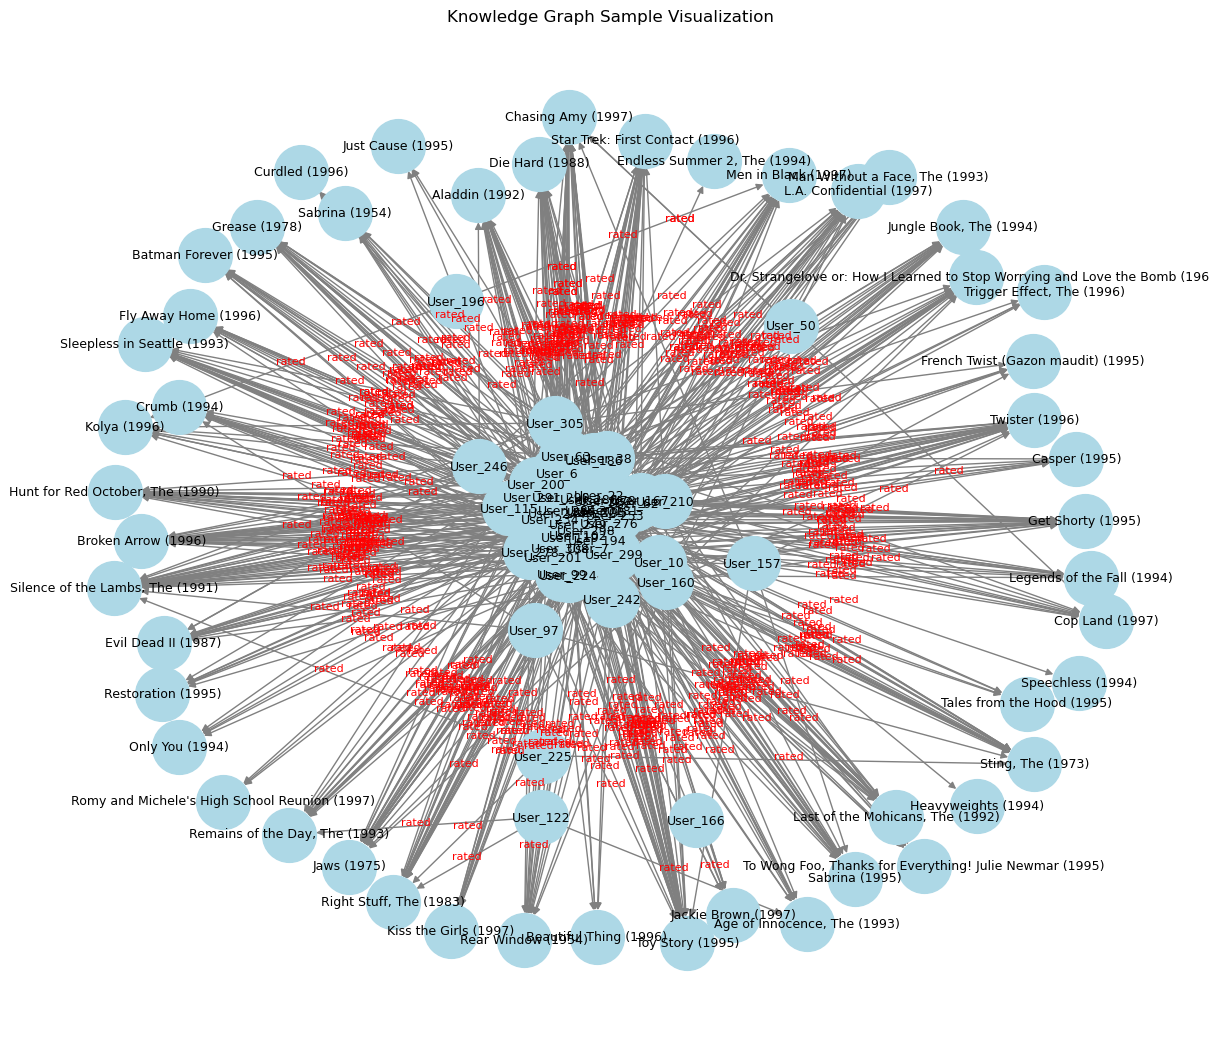

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph with multiedges
G = nx.MultiDiGraph()

# Add triplets to the graph
for head, relation, tail in triplets:
    G.add_edge(head, tail, label=relation)

print(f"\nGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Visualize a subgraph
sub_nodes = list(set([triplets[i][0] for i in range(50)] + [triplets[i][2] for i in range(50)]))
subgraph = G.subgraph(sub_nodes)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500, font_size=9)

# Draw edge labels manually for MultiDiGraph
edge_labels = {(u, v, k): d['label'] for u, v, k, d in subgraph.edges(data=True, keys=True)}
for (u, v, k), label in edge_labels.items():
    x = (pos[u][0] + pos[v][0]) / 2
    y = (pos[u][1] + pos[v][1]) / 2
    plt.text(x, y, label, fontsize=8, color='red', horizontalalignment='center')

plt.title("Knowledge Graph Sample Visualization")
plt.axis('off')
plt.show()


In [17]:
# 📌 STEP 3: Convert Knowledge Graph to GNN Input Format

import torch
from torch_geometric.data import Data

# Map each unique node to an index
node2id = {node: i for i, node in enumerate(G.nodes())}
id2node = {i: node for node, i in node2id.items()}

# Create edge index list
edge_index = [[], []]

for source, target, _ in G.edges(data=True):
    source_id = node2id[source]
    target_id = node2id[target]
    edge_index[0].append(source_id)
    edge_index[1].append(target_id)

edge_index = torch.tensor(edge_index, dtype=torch.long)

# Create one-hot features for each node
num_nodes = len(node2id)
x = torch.eye(num_nodes)

# Create PyG data object
data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[2623, 2623], edge_index=[2, 102544])


In [19]:
# 📌 STEP 4: Define and Train a GCN Model

import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, and loss function
model = GCN(in_channels=num_nodes, hidden_channels=64, out_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Dummy training loop (no labels, unsupervised)
model.train()
for epoch in range(1, 101):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = torch.norm(out)  # Unsupervised dummy loss (L2 norm)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Final embeddings
embeddings = out.detach()
print("\nNode Embeddings shape:", embeddings.shape)

Epoch 10, Loss: 2.2605
Epoch 20, Loss: 0.6114
Epoch 30, Loss: 0.2950
Epoch 40, Loss: 0.2122
Epoch 50, Loss: 0.1802
Epoch 60, Loss: 0.1273
Epoch 70, Loss: 0.1337
Epoch 80, Loss: 0.1221
Epoch 90, Loss: 0.0918
Epoch 100, Loss: 0.1338

Node Embeddings shape: torch.Size([2623, 32])


In [21]:
# 📌 STEP 5: Recommend Movies for a User

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Choose a sample user
sample_user_name = 'User_1'
sample_user_id = node2id[sample_user_name]
sample_user_embedding = embeddings[sample_user_id].unsqueeze(0)

# Get movie nodes only
movie_names = set(ratings['title'].unique())
movie_nodes = [node for node in G.nodes if node in movie_names]

movie_ids = [node2id[movie] for movie in movie_nodes]
movie_embeddings = embeddings[movie_ids]

# Compute cosine similarity between user and each movie
similarities = cosine_similarity(sample_user_embedding, movie_embeddings)[0]
sorted_indices = np.argsort(similarities)[::-1]

# Recommend Top-N
top_n = 10
recommended_movies = [movie_nodes[i] for i in sorted_indices[:top_n]]

print(f"\nTop {top_n} recommended movies for {sample_user_name}:")
for rank, movie in enumerate(recommended_movies, start=1):
    print(f"{rank}. {movie}")



Top 10 recommended movies for User_1:
1. Dadetown (1995)
2. Silence of the Palace, The (Saimt el Qusur) (1994)
3. Exit to Eden (1994)
4. Mask, The (1994)
5. Being There (1979)
6. Escape to Witch Mountain (1975)
7. Phenomenon (1996)
8. Blink (1994)
9. Wedding Singer, The (1998)
10. Sgt. Bilko (1996)


In [23]:
# 📌 STEP 6: Evaluate Recommendations with Precision@K

from collections import defaultdict

# Create a ground truth dictionary: user -> set of liked movies (rating >= 4)
ground_truth = defaultdict(set)
for _, row in ratings.iterrows():
    if row['rating'] >= 4:
        ground_truth[f"User_{row['user_id']}"] .add(row['title'])

# Evaluation function
def precision_at_k(user_id, recommended_movies, k=10):
    true_items = ground_truth.get(user_id, set())
    if not true_items:
        return None
    recommended_top_k = recommended_movies[:k]
    hits = sum([1 for movie in recommended_top_k if movie in true_items])
    return hits / k

# Evaluate for sample user
precision = precision_at_k(sample_user_name, recommended_movies, k=10)
if precision is not None:
    print(f"\nPrecision@10 for {sample_user_name}: {precision:.2f}")
else:
    print(f"\nNo ground truth data available for {sample_user_name} to evaluate.")



Precision@10 for User_1: 0.10
